# Getting a sense of the ML training/testing process

## Load data into dataframe

`rent-ideal.csv` is in the data folder in canvas. Do not distribute that file as we don't have the rights to do so.

In [2]:
import pandas as pd # Import the library and give a short alias: pd
df_rent = pd.read_csv("data/rent-ideal.csv")
df_rent.head()

,bedrooms,bathrooms,latitude,longitude,price
0,3,1.5,40.7145,-73.9425,3000
1,2,1.0,40.7947,-73.9667,5465
2,1,1.0,40.7388,-74.0018,2850
3,1,1.0,40.7539,-73.9677,3275
4,4,1.0,40.8241,-73.9493,3350


In [3]:
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
0,3,1.5,40.7145,-73.9425
1,2,1.0,40.7947,-73.9667
2,1,1.0,40.7388,-74.0018
3,1,1.0,40.7539,-73.9677
4,4,1.0,40.8241,-73.9493


In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10) # use 10 trees
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [5]:
unknown_x = [2, 1, 40.7957, -73.97] # 2 bedrooms, 1 bathroom, ...

rf.predict(unknown_x) # gets error "Expected 2D array, got 1D array instead..."

In [6]:
rf.predict([unknown_x]) # send in list of list

array([4089.41795475])

Or, We can convert to a NumPy array and reshape it into a two-dimensional matrix

In [7]:
import numpy as np
unknown_x = np.array(unknown_x).reshape(1,-1)
unknown_x

array([[  2.    ,   1.    ,  40.7957, -73.97  ]])

In [8]:
rf.predict(unknown_x)

array([4089.41795475])

## Training set error

Does the model capture relationships in the data between X and y? If the model can't make accurate predictions for apartments it trained on, then there's no hope the model will generalize to previously-unseen apartments.

In [9]:
rf.score(X,y) # R^2

0.9430142534920334

In [10]:
y_pred = rf.predict(X)
np.mean(np.abs(y - y_pred)) # mean absolute error (MAE)

189.3890458407845

In [11]:
np.mean(y)

3438.297950310559

### Noise-to-noise training error

The training error tells us very little, other than the "do not exceed speed" of our model. For example, here's a model trained purely on noise that looks pretty accurate with regards to the training error.

In [12]:
from sklearn.metrics import mean_absolute_error

rf_noise = RandomForestRegressor(n_estimators=10)
X = np.random.rand(1000, 3) # 100 rows of 3-column feature vectors full of noise
y = np.random.rand(1000)

rf_noise.fit(X, y)
rf_noise.score(X,y), mean_absolute_error(y, rf_noise.predict(X))

(0.8009313900681401, 0.1007106636585289)

RFs are so powerful they can't even find a relationship in the noise training data, but it doesn't mean they are general.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
rf_noise.fit(X_train, y_train)
rf_noise.score(X_test,y_test), mean_absolute_error(y_test, rf_noise.predict(X_test))

(-0.2632773886811368, 0.2573423589923337)

Back to the rent data set now, we see that generality is actually pretty good on the 20% test set:

In [14]:
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf.fit(X_train, y_train)
rf.score(X_test,y_test), mean_absolute_error(y_test, rf.predict(X_test))

(0.8396683165034309, 303.60861800775535)

## OOB

Compare the out of bag score from the random forest with the hold-out test set R^2.  Very close. This is very handy because we don't have to worry about validation or test sets during development work.  It's the only model I'm aware of that has this nice feature.

In [15]:
rf = RandomForestRegressor(n_estimators=30, oob_score=True)
rf.fit(X, y)
rf.oob_score_

0.8629949004441757

## Unpredictive features

Adding noise or superfluous columns can introduce a little bit of error.

In [59]:
df = df_rent.copy()
for i in range(10):
    df[f'noise{i}'] = np.random.random(len(df))
X = df.drop('price', axis=1)
y = df['price']
rf = RandomForestRegressor(n_estimators=30, oob_score=True, n_jobs=-1) # n_jobs=-1 makes it parallel
rf.fit(X, y)
rf.oob_score_

0.8039843626222564

Comparing to the test error, we see that OOB R^2 continues to be an excellent estimator.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=30, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_test,y_test), mean_absolute_error(y_test, rf.predict(X_test)), rf.oob_score_

(0.8028509072130354, 387.43143202208427, 0.7918146886232573)

We've reduced accuracy (increased bias) by the introduction of all these extra columns, but we can compensate partially by increasing the number of trees in the forest  which helps to dilute the value of superfluous columns.

In [61]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1) # n_jobs=-1 makes it parallel
rf.fit(X, y)
rf.oob_score_

0.8191186391942044

## RFs are insensitive to the scale and center (X and y)

In [20]:
X = df_rent.drop('price', axis=1)
y = df_rent['price'] * 1000 + 99
rf = RandomForestRegressor(n_estimators=30, oob_score=True)
rf.fit(X, y)
rf.oob_score_

0.8643846786184287

In [21]:
X = df_rent.drop('price', axis=1) * 1000 + 99
y = df_rent['price']
rf = RandomForestRegressor(n_estimators=30, oob_score=True)
rf.fit(X, y)
rf.oob_score_

/Users/parrt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.8634473039461673

## Must encode everything to numbers

We will deal with this specifically later, but you cannot pass in nonnumeric features to sklearn's random forest or any other model (as far as I know).

We get an error "*could not convert string to float: '101 Howard'*" because it's not a number

## When to split validation/test sets

In [22]:
rf = RandomForestRegressor(n_estimators=30, oob_score=True, n_jobs=-1)
rf.fit(X, y)
rf.oob_score_

0.8626054692695221

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
rf.score(X_test,y_test)

0.9469471775706881

What's wrong here? Why is the test score so good?  When you're OOB and test scores don't match, look for bugs.

## What the model says about the data

In [24]:
from rfpimp import *
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
longitude,0.561732
bedrooms,0.536069
latitude,0.463441
bathrooms,0.414688


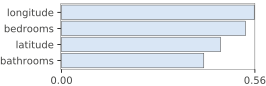

In [25]:
plot_importances(I)

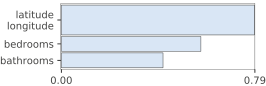

In [26]:
I = importances(rf, X_test, y_test,
                features=['bedrooms','bathrooms',['latitude','longitude']])
plot_importances(I)

## RF models don't extrapolate

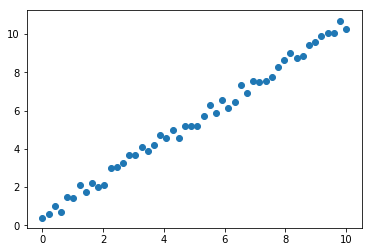

In [55]:
import matplotlib.pyplot as plt

X = np.linspace(0, 10, num=50)
y = X + np.random.random(size=len(X))
plt.scatter(X,y)

In [56]:
X = X.reshape(-1,1) # make 2D

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X, y)
for x in range(0,15):
    print(f"x={x:2d} -> y={rf.predict([[x]])[0]:.2f}")

x= 0 -> y=0.53
x= 1 -> y=1.52
x= 2 -> y=2.16
x= 3 -> y=3.63
x= 4 -> y=4.65
x= 5 -> y=5.18
x= 6 -> y=6.35
x= 7 -> y=7.53
x= 8 -> y=8.59
x= 9 -> y=9.64
x=10 -> y=10.35
x=11 -> y=10.35
x=12 -> y=10.35
x=13 -> y=10.35
x=14 -> y=10.35


## Classifier

In [28]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)


features = ['radius error', 'texture error', 'concave points error',
            'symmetry error', 'worst texture', 'worst smoothness',
            'worst symmetry']
df = df[features] # select just these features
X = df
X.head()

,radius error,texture error,concave points error,symmetry error,worst texture,worst smoothness,worst symmetry
0,1.0950,0.9053,0.01587,0.03003,17.33,0.1622,0.4601
1,0.5435,0.7339,0.01340,0.01389,23.41,0.1238,0.2750
2,0.7456,0.7869,0.02058,0.02250,25.53,0.1444,0.3613
3,0.4956,1.1560,0.01867,0.05963,26.50,0.2098,0.6638
4,0.7572,0.7813,0.01885,0.01756,16.67,0.1374,0.2364


In [29]:
np.count_nonzero(y), len(y)

(357, 569)

In [30]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)
cl.score(X_test, y_test) # this is accuracy score for classifiers

0.956140350877193

Any time you split out data, you'll get a different subset, which might look different.

In [31]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    cl = RandomForestClassifier(n_estimators=100)
    cl.fit(X_train, y_train)
    print(f"{cl.score(X_test, y_test):.2f}")

0.92
0.95
0.94
0.90
0.95
0.92
0.95
0.95
0.96
0.90
